In [64]:
# This cell comes from starting a new Kaggle notebook

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# This prints all of the file names in the input directory
#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [65]:
# This is needed if attempting to use TPU in Kaggle's environment
#!pip install seaborn

In [66]:
# CITATION: this cell is a part of the following notebook, that I slightly changed:
#
# Thite, S. (2023, October 9). UBC ovarian cancer subtype classification-CNN. Kaggle. 
# https://www.kaggle.com/code/sunilthite/ubc-ovarian-cancer-subtype-classification-cnn/notebook

import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score , auc
from sklearn.model_selection import train_test_split

import cv2
#from google.colab.patches import cv2_imshow
from PIL import Image 
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Input, Dense,Conv2D , MaxPooling2D, Flatten,BatchNormalization,Dropout
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow_hub as hub 

In [67]:
# If wanting to use a TPU
# CITATION: this code is from:
# Holbrook, R. (2020, September 24). Getting started with tpus. Kaggle. 
# https://www.kaggle.com/code/ryanholbrook/getting-started-with-tpus 
"""
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None
"""

"\ntry:\n    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() \n    print('Running on TPU ', tpu.master())\nexcept ValueError:\n    tpu = None\n"

In [68]:
# If wanting to use a TPU
# CITATION: this code is from:
# Holbrook, R. (2020, September 24). Getting started with tpus. Kaggle. 
# https://www.kaggle.com/code/ryanholbrook/getting-started-with-tpus 
"""
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 
"""

'\nif tpu:\n    tf.config.experimental_connect_to_cluster(tpu)\n    tf.tpu.experimental.initialize_tpu_system(tpu)\n    strategy = tf.distribute.experimental.TPUStrategy(tpu)\nelse:\n    strategy = tf.distribute.get_strategy() \n'

**Data loading and preprocessing**

CITATION: this section of the notebook is a part of the following notebook, that I slightly changed:

Thite, S. (2023, October 9). UBC ovarian cancer subtype classification-CNN. Kaggle. 
https://www.kaggle.com/code/sunilthite/ubc-ovarian-cancer-subtype-classification-cnn/notebook


In [69]:
train_df = pd.read_csv("/kaggle/input/UBC-OCEAN/train.csv")

In [70]:
# The paths for the medical images
path_train = "/kaggle/input/UBC-OCEAN/train_images"
path_test = "/kaggle/input/UBC-OCEAN/test_images"
train_folder = os.listdir(path_train)
test_folder = os.listdir(path_test)

In [71]:
# The paths for the thumbnail images
path_train_copy = "/kaggle/input/UBC-OCEAN/train_thumbnails"
path_test_copy = "/kaggle/input/UBC-OCEAN/test_thumbnails"
train_folder_copy = os.listdir(path_train_copy)
test_folder_copy = os.listdir(path_test_copy)

print(len(train_folder_copy))
print(len(test_folder_copy))

513
1


In [72]:
train_df_tma = train_df[train_df['is_tma']==True]

In [73]:
train_df_no_tma = train_df[train_df['is_tma']==False]

In [74]:
train_df_no_tma['image_id_path'] = [f"{i}_thumbnail.png" for i in train_df_no_tma['image_id']]

In [75]:
train_df_tma['image_id_path'] = [f"{i}.png" for i in train_df_tma['image_id']]

In [76]:
train_thumbnails_folder = train_folder_copy

In [77]:
# This cell is to calculate class weights to account for the class imbalance in this dataset
# The next cell is to print these class weight
#CITATION: this code is from the following notebook:
# Gosthipaty, A. R. (2023, October 17). [KERASCV] train and infer on thumbnails. Kaggle. 
# https://www.kaggle.com/code/aritrag/kerascv-train-and-infer-on-thumbnails/notebook 

# Perform one-hot encoding of the 'label' column and explicitly convert to integer type
df_one_hot = pd.get_dummies(train_df["label"], prefix="label").astype(int)

# Concatenate the original DataFrame with the one-hot encoded labels
weights_df = pd.concat([train_df["image_id"], df_one_hot], axis=1)

labels = weights_df[[col for col in weights_df.columns if col.startswith("label_")]].values
class_weights = np.sum(labels) - np.sum(labels, axis=0)
class_weights = class_weights / np.sum(class_weights) # Normalize the weights

class_weights = {idx:weight for idx, weight in enumerate(class_weights)}

In [78]:
print(class_weights)

{0: 0.20399628252788105, 1: 0.19237918215613384, 2: 0.14684014869888476, 3: 0.22815985130111524, 4: 0.22862453531598512}


In [79]:
image_data = []
image_label = []
path = "/kaggle/input/UBC-OCEAN/train_thumbnails"
path1="/kaggle/input/UBC-OCEAN/train_images/"
for img , label in zip(train_df_no_tma['image_id_path'],train_df_no_tma['label']):
    image = Image.open("/kaggle/input/UBC-OCEAN/train_thumbnails/"+img)
    image = image.resize((256,256))
    image = image.convert("RGB")
    image = np.array(image)
    image_data.append(image)
    image_label.append(label)

for img , label in zip(train_df_tma['image_id_path'],train_df_tma['label']):
    image = Image.open("/kaggle/input/UBC-OCEAN/train_images/"+img)
    image = image.resize((256,256))
    image = image.convert("RGB")
    image = np.array(image)
    image_data.append(image)
    image_label.append(label)

In [80]:
set(image_label)

{'CC', 'EC', 'HGSC', 'LGSC', 'MC'}

In [81]:
image_label_1 = []
for i in image_label:
    if i=="CC":
        image_label_1.append(0)
    elif i=="EC":
        image_label_1.append(1)
    elif i=="HGSC":
        image_label_1.append(2)
    elif i=="LGSC":
        image_label_1.append(3)
    elif i=="MC":
        image_label_1.append(4)

In [82]:
x = np.array(image_data)
y = np.array(image_label_1)

In [83]:
x_train , x_test, y_train, y_test = train_test_split(x,y,test_size=0.15,shuffle=True)

In [84]:
x_train_scaled = x_train/255
x_test_scaled = x_test/255

In [85]:
x_train , x_test, y_train, y_test = train_test_split(x,y,test_size=0.15,shuffle=True)

In [86]:
# This is my addition
# In some runs, I would delete some of the arrays that are no longer needed
# This is to save space in the Kaggle environment as it is limited
import gc
del x
del y
del image_data
del image_label_1
del image_label
del train_df
del train_df_tma
del train_df_no_tma
gc.collect()

141

**Experiments**

This section is mostly my code

In [87]:
# This is the function I wrote the creates a model of the first architecture with the given hyperparameter values
# The first architecture is a CNN with a convolutional layer followed my a max pooling layer, potentially repeated multiple times
# The CNN is then connected to an MLP
def getModel(model, num_layers, kernel_s, max_pool, stride, learning_rate):
    if num_layers == 1:
        model.add(Conv2D(filters=64,kernel_size=(kernel_s,kernel_s),strides=(stride,stride),activation='relu',input_shape=(256,256,3)))
        model.add(MaxPooling2D(pool_size=(max_pool,max_pool)))
    else:
        model.add(Conv2D(filters=200,kernel_size=(kernel_s,kernel_s),strides=(stride,stride),activation='relu',input_shape=(256,256,3)))
        model.add(MaxPooling2D(pool_size=(max_pool,max_pool)))
      
        for i in range(num_layers - 1):
            model.add(Conv2D(filters=200 - int(136/(num_layers - 1 - i)),kernel_size=(kernel_s,kernel_s),strides=(stride,stride),activation='relu'))
            model.add(MaxPooling2D(pool_size=(max_pool,max_pool)))
                             
    model.add(Flatten())
    model.add(Dense(units=512,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=256,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=5,activation='softmax'))

    opti = keras.optimizers.Adam(learning_rate = learning_rate)
    
    model.compile(optimizer=opti,loss="sparse_categorical_crossentropy",
                 metrics=["accuracy"])

In [89]:
# This is to utilize the TPU
# The next two lines after this one need to be indented to use this
# This is from the citation for the TPU usage at the beginning of this notebook
# with strategy.scope():    model = Sequential()
num_layers = 3
num_epochs = 5
kernel_size = 3
learning_rate = 0.1

max_pool_size = 2
stride_size = 1

model = Sequential()
getModel(model, num_layers, kernel_size, max_pool_size, stride_size, learning_rate)

# Fit data to model
# I use the class weights here
history = model.fit(x_train_scaled, y_train,
            batch_size=16,
            epochs=num_epochs,
            class_weight=class_weights)

Epoch 1/5
29/29 [==============================] - 8s 115ms/step - loss: 1062068.5000 - accuracy: 0.2385
Epoch 2/5
29/29 [==============================] - 2s 68ms/step - loss: 810.5289 - accuracy: 0.2560
Epoch 3/5
29/29 [==============================] - 2s 68ms/step - loss: 1.7705 - accuracy: 0.4004
Epoch 4/5
29/29 [==============================] - 2s 68ms/step - loss: 9.7566 - accuracy: 0.4223
Epoch 5/5
29/29 [==============================] - 2s 68ms/step - loss: 0.3311 - accuracy: 0.4245


**Model evaluation**

I used the train/test split from the beginnig of the notebook for this.

CITATION: this section of the notebook is from two notebooks:
Thite, S. (2023, October 9). UBC ovarian cancer subtype classification-CNN. Kaggle. https://www.kaggle.com/code/sunilthite/ubc-ovarian-cancer-subtype-classification-cnn/notebook 

and:
Pazze, J. S. (2023, October 9). Eda + baseline. Kaggle. https://www.kaggle.com/code/jefersonpazze/eda-baseline 

In [90]:
loss, acc = model.evaluate(x_test_scaled,y_test)
print("Accuracy on Test Data:",acc)
print()
loss, acc = model.evaluate(x_train_scaled,y_train)
print("Accuracy on Train Data:",acc)

3/3 [==============================] - 2s 336ms/step - loss: 1.4977 - accuracy: 0.3457
Accuracy on Test Data: 0.34567901492118835

15/15 [==============================] - 1s 40ms/step - loss: 1.4344 - accuracy: 0.4245
Accuracy on Train Data: 0.42450764775276184


dict_keys(['loss', 'accuracy'])


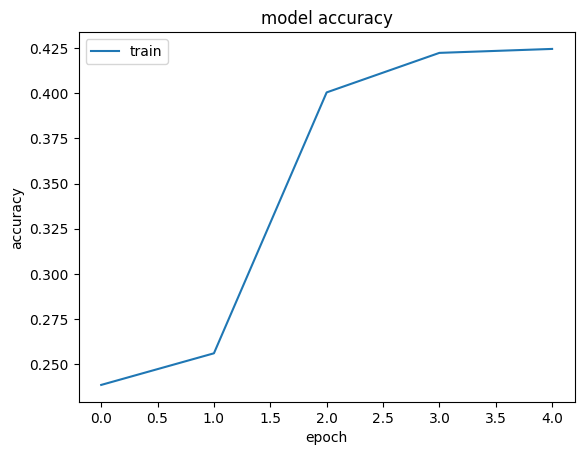

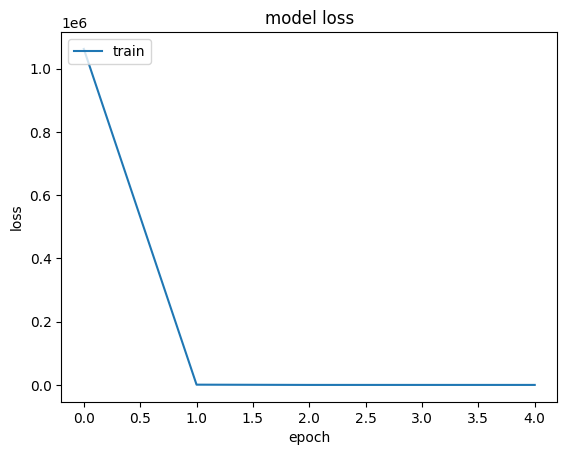

In [91]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()